# 중고나라 게시판 내용으로 중고시장 매매가 파악 및 중고가격별 게시물 특징비교

In [57]:
import requests
import lxml.html
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import konlpy
from konlpy.tag import Kkma, Twitter, Komoran, Hannanum
from datetime import datetime

조회조건

상품명 : 
조회기간 :

In [58]:
product_name = "아이폰5"
startDt = '2015-01-01'
endDt = '2016-07-01'

In [59]:
import re
def striphtml(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)



# 중고사이트에서 게시물을 파일로 쓴다.

In [60]:
urlList = []
titleList = []
costList = []
dateList = []
textList = []
for page in range(1,30):
    print(page)    
    url = 'http://www.jikgure.com/jungonara/category.php'
    param = '?cate=mobile&mode=list&page={}'.format(page)   
    response = requests.get(url+param)
    response.encoding = 'cp949'
    soup = BeautifulSoup(response.text, 'html.parser')
    
    text = ""
    for link in soup.find_all('a'):   
        # link 구분
        checkUrl ='./category.php?cate=mobile&mode=view&page={}&num'.format(page)        
        # 페이지번호 구분
        checkPageUrl ='http://www.jikgure.com/jungonara/category.php?cate=mobile&mode=list&page='

        #해당 a tag의 특징문구를 통해 link 수집
        if(link.get('href')[0:len(checkUrl)] == checkUrl):           
            if(len(link.findChildren('font')) != 0):
                if(len(link.findParent('td').find_next_siblings("td")[0].text) != 0):
                    cost = int(link.findParent('td').find_next_siblings("td")[0].text.replace(",",""))  
                else:
                    cost = int(0)
                date = link.findParent('td').find_next_siblings("td")[3].text
                date = datetime.strptime(date, '%Y/%m/%d')
                children = link.findChildren('font')                
                urlList.append(link.get('href'))                
                titleList.append(children[0].string.replace(" ","").upper())
                costList.append(cost)
                dateList.append(date)
                
                detUrl = link.get('href')     
                number = detUrl[len(detUrl)-5:]
                full = "http://www.jikgure.com/jungonara/category.php?cate=mobile&mode=view&page=&num="
                response = requests.get(full+number)
                response.encoding = 'cp949'
                oupDet = BeautifulSoup(response.text, 'html.parser')

                for listDet in oupDet.findAll('font', attrs={'class':'f3'}):
                    text += striphtml(str(listDet))
                
                textList.append(text)



     

    


    



        
        
        
        
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [61]:
import pandas
from collections import Counter


In [62]:
data = { 
           'title' : titleList
           ,'중고가' : costList
           ,'date' : dateList
            ,'text' : textList}

In [63]:
df = pandas.DataFrame(data, columns=['title','중고가','date','text'])
df_backup = df

In [64]:
import csv

In [65]:
#df.to_csv("중고폰게시판.txt", sep='\t', encoding='utf-8')
df.to_csv('jungoPhone.txt' ,encoding='utf-8')

# 웹에서 가져온 데이터파일을 가지고 작업한다.

In [66]:
tt = pandas.read_csv('jungoPhone.txt', index_col=False, header=0);
tt.drop('Unnamed: 0', axis=1, inplace=True)

In [67]:
df = tt

검색할 상품명이 들어간 게시물을 필터링한다.
검색 상품의 작성날짜 범위를 필터링한다.

In [68]:
df = df[df['title'].str.contains(product_name, na=False)
  &(df['date'] > startDt) & (df['date'] < endDt)]

df = df[df['중고가'] > 0]

In [69]:
df

,title,중고가,date,text
124,아이폰5S16GB실버A급,250000,2016-06-09,아가파오 2016년 6월 9일 23시 41분 경기 삼성...
146,아이폰532GB스페이스그레이특A급,190000,2016-06-08,아가파오 2016년 6월 9일 23시 41분 경기 삼성...
156,아이폰5S32GB골드특A급,310000,2016-06-07,아가파오 2016년 6월 8일 09시 02분 경기 삼성...
157,아이폰5S32GB스페이스그레이특A급,300000,2016-06-07,아가파오 2016년 6월 8일 09시 02분 경기 삼성...
172,아이폰5S32GB골드SKKT,290000,2016-06-06,아가파오 2016년 6월 8일 09시 02분 경기 삼성...
378,아이폰5S판매합니다.,250000,2016-05-24,해린통신 2016년 5월 25일 15시 55분 서울 삼...
385,아이폰5S64기가리퍼폰직거래합니다.,250000,2016-05-24,해린통신 2016년 5월 25일 15시 55분 서울 삼...
515,아이폰5S16GB스페이스그레이A급SKKT,270000,2016-05-16,sm맘 2016년 5월 16일 21시 03분 전국 삼성...
601,아이폰5S32GB실버A급SKKT,290000,2016-05-10,해린통신 2016년 5월 10일 13시 30분 서울 삼...
617,아이폰5S16GB스페이스그레이팝니다,240000,2016-05-09,해린통신 2016년 5월 10일 13시 30분 서울 삼...


In [70]:
tagger = Kkma()

In [71]:
mean = df['중고가'].mean()

max = df[df['중고가'] > mean] 
min = df[df['중고가'] < mean]

In [72]:
total_max_list=[]
for text in max['text'].values:
    t1 = tagger.pos(text)
    for word, tag in t1:
        if tag.startswith('NNG'):
            total_max_list.append(word)
                
                
                

In [73]:
total_min_list=[]
for text in min['text'].values:
    t1 = tagger.pos(text)
    for word, tag in t1:
        if tag.startswith('NNG'):
            total_min_list.append(word)
                

중고가격의 평균값을 구한 후 평균보다 높은 금액의 상품게시판 (total_max_list)
과 낮은 금액의 상품게시판 (total_min_list)를 구한 후 
두 게시물의 공통 문구를 제거한 후 특징비교

In [74]:
total_max_list = list(set(total_max_list)^set(total_min_list))
total_min_list = list(set(total_min_list)^set(total_max_list))

1. 평균금액 이상의 게시판 명사

In [75]:
Counter(total_max_list).most_common(20)

[('돌', 1),
 ('기간', 1),
 ('반영구적', 1),
 ('맘', 1),
 ('계', 1),
 ('글', 1),
 ('특별', 1),
 ('김', 1),
 ('매매', 1),
 ('휴대용', 1),
 ('말기', 1),
 ('강도', 1),
 ('보드', 1),
 ('인정', 1),
 ('멋', 1),
 ('메뉴', 1),
 ('기수', 1),
 ('머리', 1),
 ('별도', 1),
 ('배', 1)]

In [76]:
2. 평균금액 이하의 게시판 명사

SyntaxError: invalid syntax (<ipython-input-76-6a60e98bc20c>, line 1)

In [77]:
Counter(total_min_list).most_common(20)

[('가능', 1),
 ('액정', 1),
 ('중고', 1),
 ('기가', 1),
 ('맘', 1),
 ('송수신', 1),
 ('화이트', 1),
 ('리', 1),
 ('불', 1),
 ('통신', 1),
 ('본체', 1),
 ('상인', 1),
 ('의사', 1),
 ('호환', 1),
 ('효율성', 1),
 ('당', 1),
 ('문제', 1),
 ('골드', 1),
 ('발송', 1),
 ('이점', 1)]

조회기간 기준 groupby 후 cost값 평균값으로 대입
그래프 작성

In [78]:
df.groupby(['date']).mean()

,중고가
date,
2016-04-24,260000
2016-05-09,240000
2016-05-10,290000
2016-05-16,270000
2016-05-24,250000
2016-06-06,290000
2016-06-07,305000
2016-06-08,190000
2016-06-09,250000


In [79]:
중고사이트의 선택상품 가격추이 그래프 출력

SyntaxError: invalid syntax (<ipython-input-79-92a9fe06f64b>, line 1)

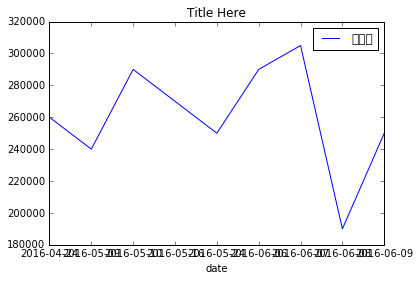

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
jungo_cost = df.groupby(['date']).mean()
jungo_cost
jungo_cost.plot(title='Title Here')

상품출고가 웹스크롤을 위한 상품별 phoneNo 하드코딩
url에 parameter 값으로 phoneNo 값이 필요함

In [81]:
phoneNm = ['갤럭시S2'
,'갤럭시S3'
,'갤럭시S4'
,'갤럭시S5'
,'갤럭시S6'
,'아이폰3'
,'아이폰4'
,'아이폰5'
,'아이폰6'
,'G2'
,'G3'
,'G4']

phoneNo = [
     '11967341'
,'8693708'
,'9975755'
,'11089244'
,'12071337'
,'2605120'
,'12441036'
,'10658174'
,'11688924'
,'10430226'
,'11478675'
,'12132527'
]

phoneInfo = { 'phoneNm' : phoneNm
            ,'phoneNo'  : phoneNo
            } 

phone = pandas.DataFrame(phoneInfo, columns=['phoneNm','phoneNo'])

In [82]:
선택상품의 phoneNo 추출

SyntaxError: invalid syntax (<ipython-input-82-88956f17c208>, line 1)

In [83]:
phoneNo = phone[phone['phoneNm'] == product_name].phoneNo


In [84]:
출고가 조회

SyntaxError: invalid syntax (<ipython-input-84-219aa35037cb>, line 1)

In [85]:


url = 'http://www.enuri.com/view/noticedetail/Goods_price_list.jsp?wg_modelno='+str(int(phoneNo))
response = requests.get(url)
response.encoding = 'cp949'
soup = BeautifulSoup(response.text, 'html.parser')
dateList = []
costList = []
for link in soup.find_all('tr'):   
    if(link.get("bgcolor") == "#FFFFFF"):
        date = link.findChildren('td')[0].text.replace("월","")
        if(date != "평균"):
            date = datetime.strptime(date, '%Y.%m')
            dateList.append(date)
            cost = link.findChildren('td')[3].text.replace(",","").replace("\xa0","")
            
            costList.append(int(cost))
                        
                   

In [86]:
costData = { 
            '출고가' : costList[:len(costList)-1]
           ,'date' : dateList[:len(dateList)-1]}


In [87]:
cdf = pandas.DataFrame(costData, columns=['date','출고가'])

In [88]:
가져온 출고가 데이터에서 선택 시간범위를 filtering

SyntaxError: invalid syntax (<ipython-input-88-b880f5d8c471>, line 1)

In [89]:
cdf = cdf[(cdf['date'] > startDt) & (cdf['date'] < endDt)]


In [90]:
출고가, 중고가 dataframe 비교

SyntaxError: invalid syntax (<ipython-input-90-ba4371b321cb>, line 1)

In [91]:
print(cdf)
print(jungo_cost)

         date     출고가
0  2015-06-01  427740
1  2015-06-01  439178
2  2015-06-01  459558
3  2015-07-01  454046
4  2015-07-01  450434
5  2015-07-01  450434
6  2015-07-01  537622
7  2015-08-01  517527
8  2015-08-01  523207
9  2015-08-01  520960
10 2015-08-01  515325
11 2015-08-01  542338
12 2015-09-01  513202
13 2015-09-01  485365
14 2015-09-01  493773
15 2015-09-01  458148
16 2015-10-01  450782
17 2015-10-01  450782
18 2015-10-01  450782
19 2015-10-01  373270
20 2015-11-01  373025
21 2015-11-01  366034
22 2015-11-01  367530
23 2015-11-01  364861
24 2015-11-01  353899
25 2015-12-01  353053
26 2015-12-01  360361
27 2015-12-01  358748
28 2015-12-01  356747
29 2016-01-01  356747
30 2016-01-01  348122
31 2016-01-01  362364
32 2016-01-01  354531
33 2016-01-01  352784
34 2016-02-01  354531
35 2016-02-01  363056
36 2016-02-01  353658
37 2016-02-01  355362
38 2016-03-01  352902
39 2016-03-01  350873
40 2016-03-01  348261
41 2016-03-01  351251
42 2016-04-01  348238
43 2016-04-01  334960
44 2016-04

In [92]:
날짜별 평균 출고가 가격추이 그래프

SyntaxError: invalid syntax (<ipython-input-92-525d476b5cc1>, line 1)

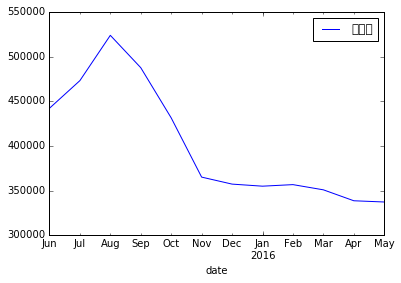

In [93]:
cdf = cdf.groupby(['date']).mean()
cdf.plot()

In [94]:
날짜별 평균 중고가 가격추이 그래프

SyntaxError: invalid syntax (<ipython-input-94-b68bc1b6f40b>, line 1)

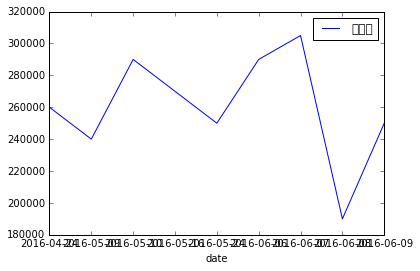

In [95]:
ax = jungo_cost.plot()



In [96]:
출고가, 중고가 그래프 비교 ( ##에러해결못하였습니다...)

SyntaxError: invalid syntax (<ipython-input-96-1750aef7cd9a>, line 1)

In [97]:
cdf.plot(ax=ax)

ValueError: ordinal must be >= 1

# 결론


1. 아이폰5 에 경우 삼성의 갤럭시, LG의 G 시리즈보다 출고가와 중고가의 가격차이가 상대적으로 적음을 알 수 있다.
2. 게시물 내용의 비교로는 "제작, 외관" 에 관한 내용이 있을 경우 평균가격보다 높다는 예측을 할 수 있고
                          "선입, 사은품" 에 관한 내용이 있을 경우 평균가보다 낮다는 결과가 나왔다.